---

**Load essential libraries**

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
import tensorflow as tf
import sys
import h5py # this library is used to save weights of the model
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix

We will consider the following toy data matrix with 6 samples and 3 possible output labels :


![data for softmax](https://1drv.ms/i/s!AjTcbXuSD3I3hsxIkL4V93-CGq8RkQ?embed=1&width=660)

In [2]:
# Data matrix
X = tf.constant([[72, 120, 37.3, 104, 32.5],
                 [85, 130, 37.0, 110, 14],
                 [68, 110, 38.5, 125, 34],
                 [90, 140, 38.0, 130, 26],
                 [84, 132, 38.3, 146, 30],
                 [78, 128, 37.2, 102, 12]])
print(X)

# Create the output labels vector
y = tf.constant(['non-diabetic',
                 'diabetic',
                 'non-diabetic',
                 'pre-diabetic',
                 'diabetic',
                 'pre-diabetic'])

# One-hot encoding of output labels using scikit-learnn
ohc = OneHotEncoder()
Y = ohc.fit_transform(y.numpy().reshape(-1, 1))
print(Y.todense())

tf.Tensor(
[[ 72.  120.   37.3 104.   32.5]
 [ 85.  130.   37.  110.   14. ]
 [ 68.  110.   38.5 125.   34. ]
 [ 90.  140.   38.  130.   26. ]
 [ 84.  132.   38.3 146.   30. ]
 [ 78.  128.   37.2 102.   12. ]], shape=(6, 5), dtype=float32)
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


---

Define the linear layer (dense layer) where the raw scores are calculated through the linear operation:
$$\underbrace{\mathbf{Z}}_{\color{red}{6\times3}} = \underbrace{\begin{bmatrix}{\mathbf{z}^{(0)}}^\mathrm{T}\\{\mathbf{z}^{(1)}}^\mathrm{T}\\{\mathbf{z}^{(2)}}^\mathrm{T}\\{\mathbf{z}^{(3)}}^\mathrm{T}\\{\mathbf{z}^{(4)}}^\mathrm{T}\\{\mathbf{z}^{(5)}}^\mathrm{T}\end{bmatrix}}_{\color{red}{6\times3}}=\underbrace{\begin{bmatrix}{\mathbf{x}^{(0)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\mathbf{x}^{(1)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\mathbf{x}^{(2)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\mathbf{x}^{(3)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\mathbf{x}^{(4)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\mathbf{x}^{(5)}}^\mathrm{T}\mathbf{W}+{\color{orange}{\mathbf{b}}^\mathrm{T}}\end{bmatrix}}_{\color{red}{6\times3}} = \underbrace{\begin{bmatrix}{\mathbf{x}^{(0)}}^\mathrm{T}\mathbf{W}\\{\mathbf{x}^{(1)}}^\mathrm{T}\mathbf{W}\\{\mathbf{x}^{(2)}}^\mathrm{T}\mathbf{W}\\{\mathbf{x}^{(3)}}^\mathrm{T}\mathbf{W}\\{\mathbf{x}^{(4)}}^\mathrm{T}\mathbf{W}\\{\mathbf{x}^{(5)}}^\mathrm{T}\mathbf{W}\end{bmatrix}}_{\color{red}{6\times3}} + \underbrace{\begin{bmatrix}{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\end{bmatrix}}_{\color{red}{6\times3}}=\underbrace{\begin{bmatrix}{\mathbf{x}^{(0)}}^\mathrm{T}\\{\mathbf{x}^{(1)}}^\mathrm{T}\\{\mathbf{x}^{(2)}}^\mathrm{T}\\{\mathbf{x}^{(3)}}^\mathrm{T}\\{\mathbf{x}^{(4)}}^\mathrm{T}\\{\mathbf{x}^{(5)}}^\mathrm{T}\end{bmatrix}}_{\color{red}{6\times5}}\underbrace{\mathbf{W}}_{\color{red}{5\times3}}=\underbrace{\underbrace{\mathbf{X}}_{6\times 5}\underbrace{\mathbf{W}}_{5\times 3}}_{\color{red}{6\times3}} + \underbrace{\begin{bmatrix}{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\\{\color{orange}{\mathbf{b}}^\mathrm{T}}\end{bmatrix}}_{\color{red}{6\times3}}.$$

---

In [3]:
## Define the linear layer
class LinearLayer(tf.keras.layers.Layer):
  # Constructor method
  def __init__(self, nodes = 2):
    super().__init__() # use the parent class's constructor
    self.nodes = nodes

  # Method to initialize the variables (weights and bias)
  # associated with the layer
  def build(self, input_shape):
    self.W = self.add_weight(shape = (input_shape[-1], self.nodes),
                             dtype = tf.float32,
                             initializer = tf.initializers.RandomNormal())
    self.b = self.add_weight(shape = (self.nodes,),
                             dtype = tf.float32,
                             initializer = tf.initializers.RandomUniform())

  # Method to perform the layer's computation based on the input
  def call(self, input):
    output = tf.linalg.matmul(input, self.W) + self.b
    # Note that we don't need to transpose b above because of broadcasting
    return(output)

---

Define the softmax layer

---

In [4]:
## Define the softmax layer
class SoftmaxLayer(tf.keras.layers.Layer):
  # Constructor method
  def __init__(self):
    super().__init__()
    self.activation = tf.keras.layers.Softmax()

  # Method to perform the layer's computation based on the input
  def call(self, input):
    output = self.activation(input)
    return(output)

---

Define the softmax classifier model

---

In [5]:
## Define the softmax classifier model
class SoftmaxClassifierModel(tf.keras.Model):
  def __init__(self, nodes = 2):
    super().__init__()
    self.nodes = nodes
    self.linearLayer = LinearLayer(self.nodes)
    self.softmaxLayer = SoftmaxLayer()

  def call(self, input):
    output = self.linearLayer(input)
    output = self.softmaxLayer(output)
    return(output)

---

Define categorical crossentropy loss function which is defined as $$\color{yellow}{-\log(\text{predicted probability that a sample belongs its correct class})}$$

For example, consider a sample with

- true_label = [$\color{yellow}{1}$ 0 0]
- predicted_label = [$\color{yellow}{0.05}$, 0.99, 0.05]

categorical crossentropy loss = $-\log(\color{yellow}{0.05}).$

---

In [6]:
def loss_fn(true_labels, predicted_labels):
  loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(true_labels, predicted_labels))
  return(loss)

---

Apply the softmax classifier model to the toy data set and calculate the loss.

---

In [7]:
## Apply the softmax classifier model to the toy data set and calculate the loss
# Instantiate the model object
model = SoftmaxClassifierModel(3) # invokes the constructore and sets up the layers
#print(model(X))
# Calculate average data loss
loss_fn(Y.todense(), model(X))

<tf.Tensor: shape=(), dtype=float32, numpy=9.394323>

---

Now we will apply the softmax classifier model to the MNIST data.

---

In [8]:
## Load MNIST data (note that shape of X_train and y_train)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print(X_train.shape)
print(y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)


In [9]:
## Reshape X_train and X_test such that the samples are along the rows
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print(X_train_reshaped.shape)

(60000, 784)


In [10]:
## Min-max scale the images using scikit-learn
mms = MinMaxScaler()
X_train_reshaped_scaled = mms.fit_transform(X_train_reshaped)
X_test_reshaped_scaled = mms.transform(X_test_reshaped)

In [11]:
## Problem parameters
num_samples_train = X_train_reshaped_scaled.shape[0]
num_samples_test = X_test_reshaped_scaled.shape[0]
num_features = X_train_reshaped_scaled.shape[1]
num_labels = len(np.unique(y_train))
print(f'No. of training samples = {num_samples_train},\
 No. of test samples = {num_samples_test}, \
 no. of features = {num_features}, no. of labels = {num_labels}')

No. of training samples = 60000, No. of test samples = 10000,  no. of features = 784, no. of labels = 10


In [12]:
## One-hot encode output labels using scikit-learn (observe the shape of Y_train)
ohc = OneHotEncoder()
Y_train = ohc.fit_transform(y_train.reshape(-1, 1))
Y_test = ohc.transform(y_test.reshape(-1, 1))
Y_train.shape

(60000, 10)

---

Train the softmax classifier model

---

In [14]:
## Train the softmax classifier model
nodes = num_labels # this is the number of output labels
model = SoftmaxClassifierModel(nodes)

# Gradient descent
maxiter = 10
lr = 1e-03
optimizer = tf.optimizers.RMSprop(learning_rate = lr) # optimizer object
# Empty lists to store training and test losses every step
loss_train = [None]*maxiter
loss_test = [None]*maxiter
k = 0
while k < maxiter:
  with tf.GradientTape() as tape:
    Yhat = model(X_train_reshaped_scaled)
    L = loss_fn(Y_train.todense(), Yhat)
  # Append training and test loss values
  loss_train[k] = L
  loss_test[k] = loss_fn(Y_test.todense(), model.predict(X_test_reshaped_scaled))
  print(f'Iteration {k+1}, Training loss = {loss_train[k]}, Test loss = {loss_test[k]}')
  # Calculate gradients w.r.t. all trainable variables
  gradients = tape.gradient(L, model.trainable_variables)
  # Update all trainable variables using the gradients
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  k = k+1

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 1, Training loss = 2.3282883167266846, Test loss = 2.3242714405059814
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2, Training loss = 2.173299551010132, Test loss = 2.1663424968719482
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 3, Training loss = 2.0704503059387207, Test loss = 2.061464548110962
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 4, Training loss = 1.9888293743133545, Test loss = 1.9784045219421387
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 5, Training loss = 1.9196833372116089, Test loss = 1.908043384552002
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 6, Training loss = 1.8589532375335693, Test loss = 1.846299171447754
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 7, Training loss = 1.8044029474258423, Test loss = 1.790860891342163
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Iteration 8, Training loss = 1.754642128944397, Test loss = 1.7403132915496826
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/st

In [15]:
# Gradient descent
maxiter = 100

# learning rates
lr2 = 1e-02
lr3 = 1e-03
lr4 = 1e-04
lr5 = 1e-05

# optimizer objects
optimizer2 = tf.optimizers.RMSprop(learning_rate = lr2)
optimizer3 = tf.optimizers.RMSprop(learning_rate = lr3)
optimizer4 = tf.optimizers.RMSprop(learning_rate = lr4)
optimizer5 = tf.optimizers.RMSprop(learning_rate = lr5)

# Empty lists to store training and test losses every step
loss_train_2 = [None] * maxiter
loss_test_2 = [None] * maxiter

loss_train_3 = [None] * maxiter
loss_test_3 = [None] * maxiter

loss_train_4 = [None] * maxiter
loss_test_4 = [None] * maxiter

loss_train_5 = [None] * maxiter
loss_test_5 = [None] * maxiter

k = 0
while k < maxiter:
    # For learning rate = 1e-02
    with tf.GradientTape() as tape2:
        Yhat2 = model(X_train_reshaped_scaled)
        L2 = loss_fn(Y_train.todense(), Yhat2)
    loss_train_2[k] = L2
    loss_test_2[k] = loss_fn(Y_test.todense(), model.predict(X_test_reshaped_scaled))
    gradients2 = tape2.gradient(L2, model.trainable_variables)
    optimizer2.apply_gradients(zip(gradients2, model.trainable_variables))

    # For learning rate = 1e-03
    with tf.GradientTape() as tape3:
        Yhat3 = model(X_train_reshaped_scaled)
        L3 = loss_fn(Y_train.todense(), Yhat3)
    loss_train_3[k] = L3
    loss_test_3[k] = loss_fn(Y_test.todense(), model.predict(X_test_reshaped_scaled))
    gradients3 = tape3.gradient(L3, model.trainable_variables)
    optimizer3.apply_gradients(zip(gradients3, model.trainable_variables))

    # For learning rate = 1e-04
    with tf.GradientTape() as tape4:
        Yhat4 = model(X_train_reshaped_scaled)
        L4 = loss_fn(Y_train.todense(), Yhat4)
    loss_train_4[k] = L4
    loss_test_4[k] = loss_fn(Y_test.todense(), model.predict(X_test_reshaped_scaled))
    gradients4 = tape4.gradient(L4, model.trainable_variables)
    optimizer4.apply_gradients(zip(gradients4, model.trainable_variables))

    # For learning rate = 1e-05
    with tf.GradientTape() as tape5:
        Yhat5 = model(X_train_reshaped_scaled)
        L5 = loss_fn(Y_train.todense(), Yhat5)
    loss_train_5[k] = L5
    loss_test_5[k] = loss_fn(Y_test.todense(), model.predict(X_test_reshaped_scaled))
    gradients5 = tape5.gradient(L5, model.trainable_variables)
    optimizer5.apply_gradients(zip(gradients5, model.trainable_variables))

    # Increment iteration counter
    k += 1

    # Print progress
    print(f'Iteration {k}:')
    print(f'Train loss at lr = 1e-02 = {loss_train_2[k-1]}, Test loss = {loss_test_2[k-1]}')
    print(f'Train loss at lr = 1e-03 = {loss_train_3[k-1]}, Test loss = {loss_test_3[k-1]}')
    print(f'Train loss at lr = 1e-04 = {loss_train_4[k-1]}, Test loss = {loss_test_4[k-1]}')
    print(f'Train loss at lr = 1e-05 = {loss_train_5[k-1]}, Test loss = {loss_test_5[k-1]}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1:
Train loss at lr = 1e-02 = 1.6260508298873901, Test loss = 1.6097813844680786
Train loss at lr = 1e-03 = 0.9353564381599426, Test loss = 0.9128656983375549
Train loss at lr = 1e-04 = 0.8805156350135803, Test loss = 0.8552072048187256
Train loss at lr = 1e-05 = 0.8760480284690857, Test loss = 0.8508074283599854
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2:
Train loss at lr = 1e-02 = 0.8756105899810791, Test loss = 0.8503752946853638
Train loss at lr = 1e-03 = 0.9510481953620911, Test loss = 0.9330057501792908
Train loss at lr = 1e-04 = 0.8295163512229919, Test loss = 0.80876225233078
Train loss at lr = 1e-05 = 0.8197372555732727, Test loss = 0.7987551093101501
313/313 ━━━━━━━━━━━━━━━━

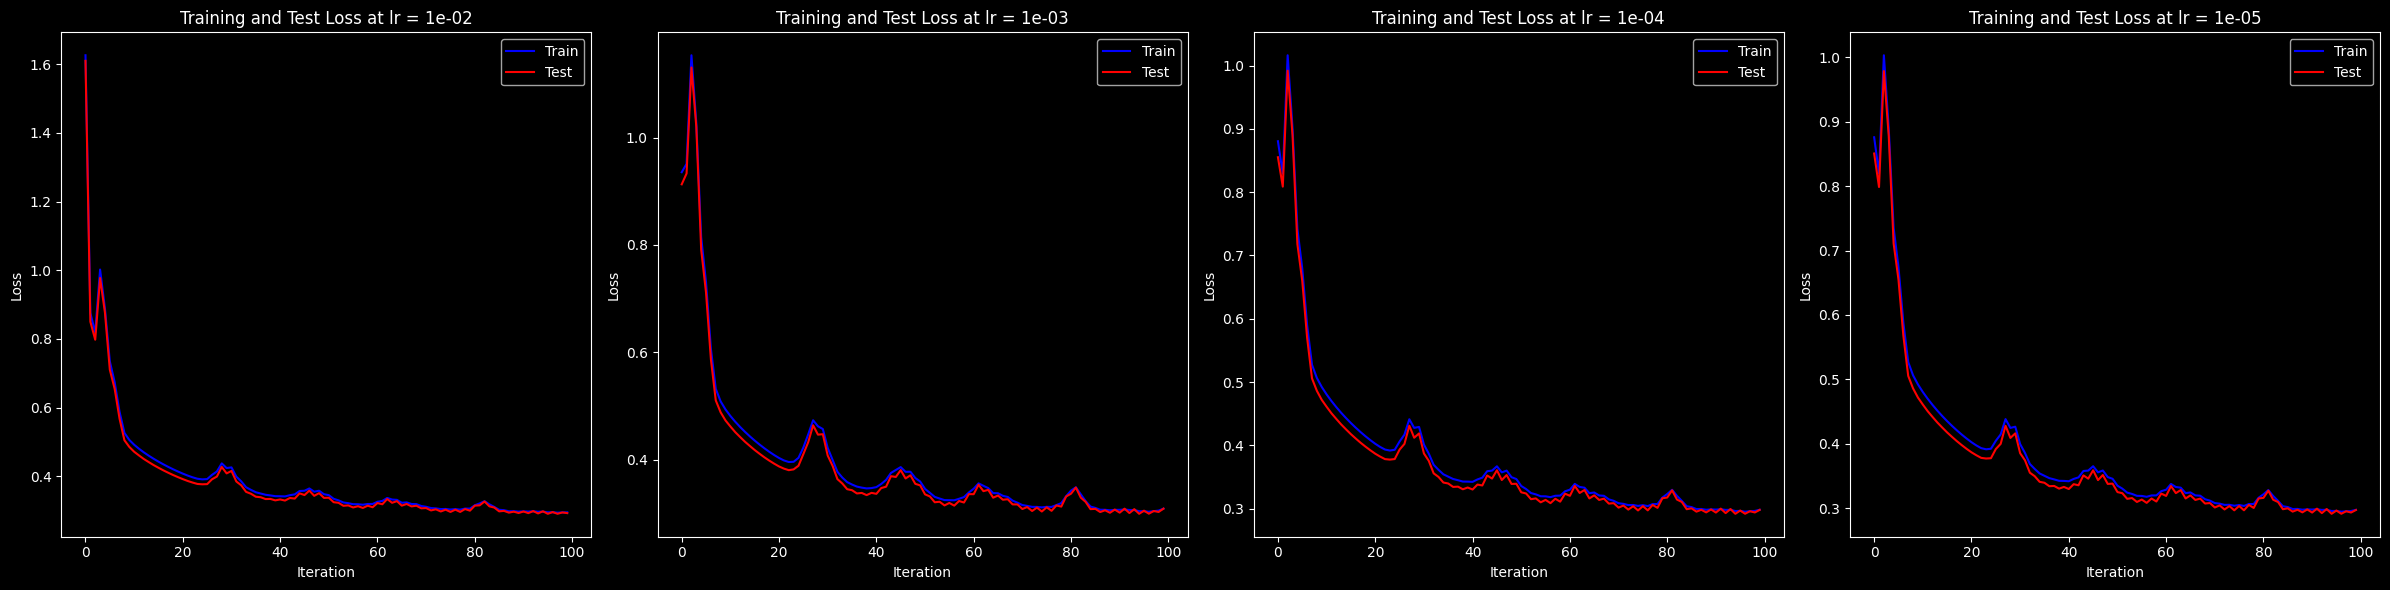

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot for the first set of losses
axes[0].plot(loss_train_2, 'b', label='Train')
axes[0].plot(loss_test_2, 'r', label='Test')
axes[0].set_title('Training and Test Loss at lr = 1e-02')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot for the second set of losses
axes[1].plot(loss_train_3, 'b', label='Train')
axes[1].plot(loss_test_3, 'r', label='Test')
axes[1].set_title('Training and Test Loss at lr = 1e-03')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Plot for the third set of losses
axes[2].plot(loss_train_4, 'b', label='Train')
axes[2].plot(loss_test_4, 'r', label='Test')
axes[2].set_title('Training and Test Loss at lr = 1e-04')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Loss')
axes[2].legend()

# Plot for the fourth set of losses
axes[3].plot(loss_train_5, 'b', label='Train')
axes[3].plot(loss_test_5, 'r', label='Test')
axes[3].set_title('Training and Test Loss at lr = 1e-05')
axes[3].set_xlabel('Iteration')
axes[3].set_ylabel('Loss')
axes[3].legend()

plt.tight_layout()
plt.show()

sir, i think the lr = 1e-03 is better compared to the other learning rates
from the plots i think it gives the least loss considering the 100 epochs
small loss value on test set then i think its when lr = 1e-02

---

Plot training and test loss in the same figure

---

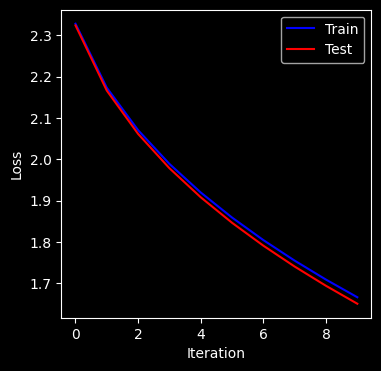

In [17]:
## Plot the training and test loss
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.plot(loss_train, 'b', label = 'Train')
ax.plot(loss_test, 'r', label = 'Test')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend();

---

Assess model performance on test data

---

In [18]:
## Assess model performance on test data
Yhat = model.predict(X_test_reshaped_scaled)

ypred = np.argmax(Yhat, axis = 1) # predicted labels for the test samples
ytrue = np.asarray(np.argmax(Y_test, axis = 1)).flatten() # truenlabels for the test samples
print('Accuracy on test data = %3.2f'%(np.mean(ytrue == ypred)*100))
# Print confusion matrix
print(confusion_matrix(ytrue, ypred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy on test data = 91.57
[[ 963    0    0    3    0    2   10    1    1    0]
 [   0 1122    2    2    0    1    4    1    3    0]
 [  12   18  893   32    8    0   13   10   38    8]
 [   3    1   12  945    0   14    3    7   13   12]
 [   1    1    3    1  884    0   17    2    8   65]
 [  12    6    2   53    8  742   23    5   29   12]
 [   8    3    4    2    6    7  927    1    0    0]
 [   2    9   22   11    6    0    0  920    1   57]
 [  13   13    6   44    8   25   13    8  813   31]
 [  12    6    1   16   14    2    0    8    2  948]]


Image classified as 9


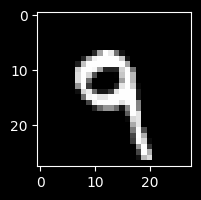

In [20]:
## Plot a random test sample with its predicted label printed above the plot
test_index = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1, 1, figsize = (2, 2))
print(f'Image classified as {ypred[test_index]}')
ax.imshow(tf.reshape(X_test_reshaped_scaled[test_index], [28, 28]).numpy(), cmap = 'gray');